# TMY to Power Tutorial

## PVLIB toolbox

Most of the code below is from the tmy_to_power notebook from the pvlib git repo.

The original tutorial uses TMY data to obtain AC power using the SAPM (Sandia PV Model). We will use it to predict production from solar photovoltaic panels with random weather inputs. 

Table of contents:
1. [Setup](#Setup)
2. [Load TMY data](#Load-TMY-data)
2. [Calculate modeling intermediates](#Calculate-modeling-intermediates)
2. [DC power using SAPM](#DC-power-using-SAPM)
2. [AC power using SAPM](#AC-power-using-SAPM)


### Notes

This tutorial has been tested against the following package versions:
* pvlib 0.3.0
* Python 2.7.10
* IPython 3.2
* pandas 0.16.2

It should work with other Python and Pandas versions. It requires pvlib >= 0.3.0 and IPython >= 3.0.

Original Authors:
* Will Holmgren (@wholmgren), University of Arizona, July 2015, March 2016.
* Rob Andrews (@Calama-Consulting), Heliolytics, June 2014

## Setup

These are just your standard interactive scientific python imports that you'll get very used to using.

In [1]:
# built-in python modules
import os
import inspect

# scientific python add-ons
import numpy as np
import pandas as pd

# plotting stuff
# first line makes the plots appear in the notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib as mpl
# seaborn makes your plots look better
try:
    import seaborn as sns
    sns.set(rc={"figure.figsize": (12, 6)})
    sns.set_color_codes()
except ImportError:
    print('We suggest you install seaborn using conda or pip and rerun this cell')

# Import the pvlib library
import pvlib

# Import the file input-output module.
import wfileio as wf

## Load TMY data

pvlib comes with a couple of TMY files, and we'll use one of them for simplicity. You could also load a file from disk, or specify a url. See this NREL website for a list of TMY files:

http://rredc.nrel.gov/solar/old_data/nsrdb/1991-2005/tmy3/by_state_and_city.html

In [2]:
# Find the absolute file path to your pvlib installation
pvlib_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvlib)))

# Path to a data file
path_tmy_data = os.path.join('..', 'ddn', 'IND_UT_Dehradun.421110_ISHRAE2014.epw')

# read tmy data with year values coerced to a single year
tmy_data, locdata, header, _ = wf.get_weather('tmy_data', path_tmy_data, ftype='epw')
tmy_data.index.name = 'Time'

# TMY data seems to be given as hourly data with time stamp at the end
# shift the index 30 Minutes back for calculation of sun positions
# tmy_data = tmy_data.shift(freq='-30Min')

Running weather file reader for station tmy_data. Expecting format epw.



The file handling above looks complicated because we're trying to account for the many different ways that people will run this notebook on their systems. You can just put a simple string path into the ``readtmy3`` function if you know where the file is.

Let's look at the imported version of the TMY file.

In [3]:
tmy_data.head()

,year,month,day,hour,minute,qualflags,tdb,tdp,rh,atmpr,...,tsky,osky,vis,chgt,pwo,pwc,pwt,aopt,sdpt,slast
Time,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,2017,1,1,1,0,?9?9?9?9E0?9?9?9?9*9?9?9?9?9*9?9?9?9?9*_*9*9,6.7,4.7,87,94000,...,0,0,2.0,77777,9,999999999,129,0.0,0,88
2017-01-01 01:00:00,2017,1,1,2,0,?9?9?9?9E0?9?9?9?9*9?9?9?9?9*9?9?9?9?9*_*9*9,6.7,4.2,84,94000,...,0,0,2.0,77777,9,999999999,120,0.0,0,88
2017-01-01 02:00:00,2017,1,1,3,0,?9?9?9?9E0?9?9?9?9*9?9?9?9?9*9?9?9?9?9*_*9*9,6.1,3.7,85,94000,...,0,0,2.0,77777,9,999999999,120,0.0,0,88
2017-01-01 03:00:00,2017,1,1,4,0,?9?9?9?9E0?9?9?9?9*9?9?9?9?9*9?9?9?9?9*_*9*9,6.1,3.8,85,94000,...,0,0,2.0,77777,9,999999999,120,0.0,0,88
2017-01-01 04:00:00,2017,1,1,5,0,?9?9?9?9E0?9?9?9?9*9?9?9?9?9*9?9?9?9?9*_*9*9,5.6,3.3,85,94000,...,0,0,2.0,77777,9,999999999,120,0.0,0,88


This is a ``pandas DataFrame`` object. It has a lot of great properties that are beyond the scope of our tutorials.

Plot the GHI data from the TMY file

Text(0,0.5,'Irradiance (W/m**2)')

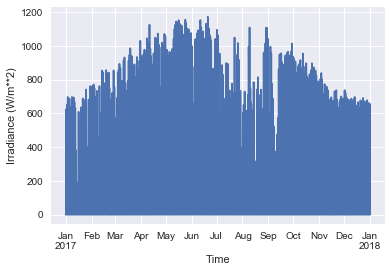

In [4]:
tmy_data['ghi'].plot()
plt.ylabel('Irradiance (W/m**2)')

## Calculate modeling intermediates

Before we can calculate power for all times in the TMY file, we will need to calculate:
* solar position 
* extra terrestrial radiation
* airmass
* angle of incidence
* POA sky and ground diffuse radiation
* cell and module temperatures

First, define some PV system parameters.

In [5]:
surface_tilt = 30
surface_azimuth = 180  # pvlib uses 0=North, 90=East, 180=South, 270=West convention
albedo = 0.2

# create pvlib Location object based on meta data
sand_point = pvlib.location.Location(np.double(locdata['lat']), np.double(locdata['long']), tz='Asia/Calcutta', 
                                     altitude=np.double(locdata['alt']), name='tmy_data')
print(sand_point)
print(type(sand_point.latitude))

Location: 
  name: tmy_data
  latitude: 30.32
  longitude: 78.03
  altitude: 682.0
  tz: Asia/Calcutta
<class 'numpy.float64'>


### Solar position

Calculate the solar position for all times in the TMY file. 

The default solar position algorithm is based on Reda and Andreas (2004). Our implementation is pretty fast, but you can make it even faster if you install [``numba``](http://numba.pydata.org/#installing) and use add  ``method='nrel_numba'`` to the function call below.

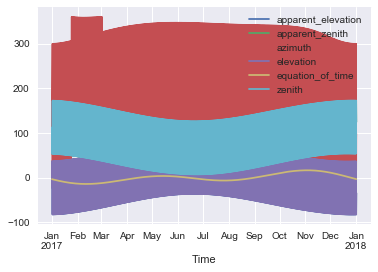

In [6]:
solpos = pvlib.solarposition.get_solarposition(tmy_data.index, sand_point.latitude, sand_point.longitude)

solpos.plot()

The funny looking jump in the azimuth is just due to the coarse time sampling in the TMY file.

### DNI ET

Calculate extra terrestrial radiation. This is needed for many plane of array diffuse irradiance models.

Text(0,0.5,'Extra terrestrial radiation (W/m**2)')

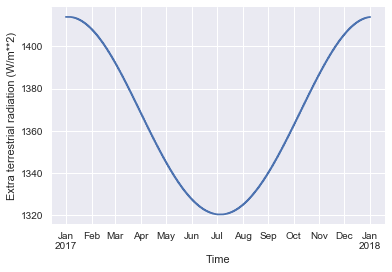

In [7]:
# the extraradiation function returns a simple numpy array
# instead of a nice pandas series. We will change this
# in a future version
dni_extra = pvlib.irradiance.extraradiation(tmy_data.index)
dni_extra = pd.Series(dni_extra, index=tmy_data.index)

dni_extra.plot()
plt.ylabel('Extra terrestrial radiation (W/m**2)')

### Airmass

Calculate airmass. Lots of model options here, see the ``atmosphere`` module tutorial for more details.

Text(0,0.5,'Airmass')

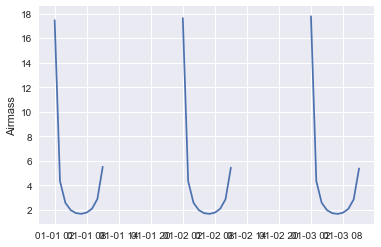

In [8]:
airmass = pvlib.atmosphere.relativeairmass(solpos['apparent_zenith'])

plt.plot(airmass.iloc[0:72])
# airmass.plot()
plt.ylabel('Airmass')

The funny appearance is due to aliasing and setting invalid numbers equal to ``NaN``. Replot just a day or two and you'll see that the numbers are right.

### POA sky diffuse

Use the Hay Davies model to calculate the plane of array diffuse sky radiation. See the ``irradiance`` module tutorial for comparisons of different models.

Text(0,0.5,'Irradiance (W/m**2)')

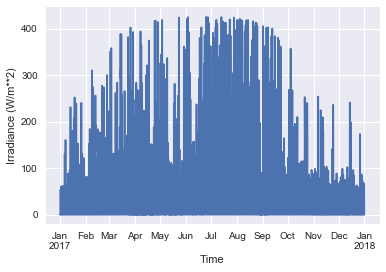

In [9]:
poa_sky_diffuse = pvlib.irradiance.haydavies(surface_tilt, surface_azimuth,
                                             tmy_data['dhi'], tmy_data['dni'], dni_extra,
                                             solpos['apparent_zenith'], solpos['azimuth'])

# There are some numerical errors in the sky diffuse calculation where the value spikes.
# We take the quantities that are larger than the ambient sky diffuse radiation and interpolate them. 
poa_sky_diffuse[poa_sky_diffuse > tmy_data.dhi] = np.NaN
poa_sky_diffuse = poa_sky_diffuse.interpolate(method='time')

poa_sky_diffuse.plot()
plt.ylabel('Irradiance (W/m**2)')

### POA ground diffuse

Calculate ground diffuse. We specified the albedo above. You could have also provided a string to the ``surface_type`` keyword argument.

Text(0,0.5,'Irradiance (W/m**2)')

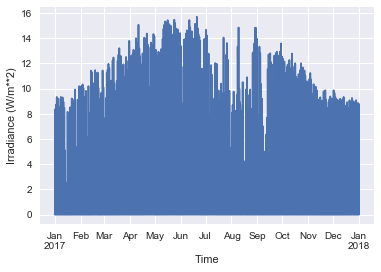

In [10]:
poa_ground_diffuse = pvlib.irradiance.grounddiffuse(surface_tilt, tmy_data['ghi'], albedo=albedo)

poa_ground_diffuse.plot()
plt.ylabel('Irradiance (W/m**2)')

### AOI

Calculate AOI

Text(0,0.5,'Angle of incidence (deg)')

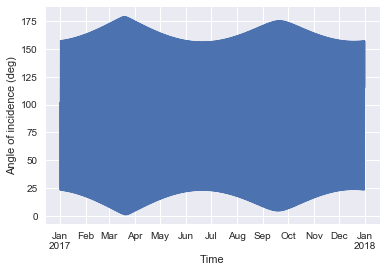

In [11]:
aoi = pvlib.irradiance.aoi(surface_tilt, surface_azimuth, solpos['apparent_zenith'], solpos['azimuth'])

aoi.plot()
plt.ylabel('Angle of incidence (deg)')

Note that AOI has values greater than 90 deg. This is ok.

### POA total

Calculate POA irradiance

Text(0.5,1,'POA Irradiance')

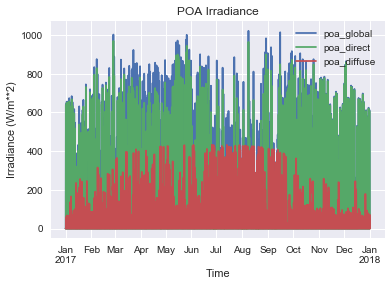

In [12]:
poa_irrad = pvlib.irradiance.globalinplane(aoi, tmy_data['dni'], poa_sky_diffuse, poa_ground_diffuse)

poa_irrad.plot()
plt.ylabel('Irradiance (W/m**2)')
plt.title('POA Irradiance')

### Cell and module temperature

Calculate pv cell and module temperature

Text(0,0.5,'Temperature (degC)')

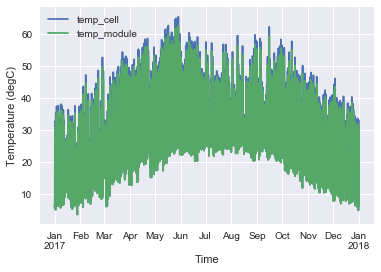

In [14]:
pvtemps = pvlib.pvsystem.sapm_celltemp(poa_irrad['poa_global'], tmy_data['wspd'], tmy_data['tdb'])

pvtemps.plot()
plt.ylabel('Temperature (degC)')

## DC power using SAPM

Get module data from the web.

In [15]:
sandia_modules = pvlib.pvsystem.retrieve_sam(name='SandiaMod')

Choose a particular module

In [16]:
sandia_module = sandia_modules.Canadian_Solar_CS5P_220M___2009_
sandia_module

Vintage                                                          2009
Area                                                            1.701
Material                                                         c-Si
Cells_in_Series                                                    96
Parallel_Strings                                                    1
Isco                                                          5.09115
Voco                                                          59.2608
Impo                                                          4.54629
Vmpo                                                          48.3156
Aisc                                                         0.000397
Aimp                                                         0.000181
C0                                                            1.01284
C1                                                         -0.0128398
Bvoco                                                        -0.21696
Mbvoc               

Calculate the effective irradiance

In [17]:
effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(poa_irrad.poa_direct, poa_irrad.poa_diffuse, airmass, aoi, sandia_module)

C:\Miniconda3\lib\site-packages\pvlib\pvsystem.py:1463: RuntimeWarning: invalid value encountered in maximum
  spectral_loss = np.maximum(0, np.polyval(am_coeff, airmass_absolute))


Run the SAPM using the parameters we calculated above.

                     i_sc  i_mp  v_oc  v_mp  p_mp  i_x  i_xx
Time                                                        
2017-01-01 00:00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2017-01-01 01:00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2017-01-01 02:00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2017-01-01 03:00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2017-01-01 04:00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0


C:\Miniconda3\lib\site-packages\pvlib\pvsystem.py:1317: RuntimeWarning: divide by zero encountered in log
  module['Voco'] + module['Cells_in_Series']*delta*np.log(Ee) +
C:\Miniconda3\lib\site-packages\pvlib\pvsystem.py:1323: RuntimeWarning: divide by zero encountered in log
  module['C3']*module['Cells_in_Series']*((delta*np.log(Ee)) ** 2) +


Text(0,0.5,'DC Power (W)')

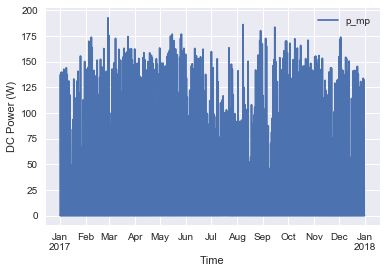

In [18]:
sapm_out = pvlib.pvsystem.sapm(effective_irradiance, pvtemps.temp_cell, sandia_module)
print(sapm_out.head())

sapm_out[['p_mp']].plot()
plt.ylabel('DC Power (W)')

## DC power using single diode

In [19]:
cec_modules = pvlib.pvsystem.retrieve_sam(name='CECMod')
cec_module = cec_modules.Canadian_Solar_CS5P_220M

In [20]:
photocurrent, saturation_current, resistance_series, resistance_shunt, nNsVth = (
    pvlib.pvsystem.calcparams_desoto(poa_irrad.poa_global,
                                 temp_cell=pvtemps['temp_cell'],
                                 alpha_isc=cec_module['alpha_sc'],
                                 module_parameters=cec_module,
                                 EgRef=1.121,
                                 dEgdT=-0.0002677) )

In [21]:
single_diode_out = pvlib.pvsystem.singlediode(photocurrent, saturation_current,
                                              resistance_series, resistance_shunt, nNsVth)

C:\Miniconda3\lib\site-packages\pvlib\pvsystem.py:1919: RuntimeWarning: overflow encountered in exp
  (Gsh[idx_p]*a[idx_p]))


Text(0,0.5,'DC Power (W)')

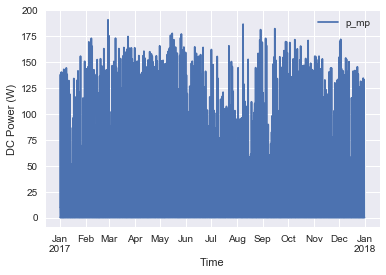

In [22]:
single_diode_out[['p_mp']].plot()
plt.ylabel('DC Power (W)')

## AC power using SAPM

Get the inverter database from the web

In [23]:
sapm_inverters = pvlib.pvsystem.retrieve_sam('sandiainverter')

Choose a particular inverter

In [28]:
sapm_inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_']
sapm_inverter

Vac          208.000000
Paco         250.000000
Pdco         259.522050
Vdco          40.242603
Pso            1.771614
C0            -0.000025
C1            -0.000090
C2             0.000669
C3            -0.018900
Pnt            0.020000
Vdcmax        65.000000
Idcmax        10.000000
Mppt_low      20.000000
Mppt_high     50.000000
Name: ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_, dtype: float64

Text(0,0.5,'AC Power (W)')

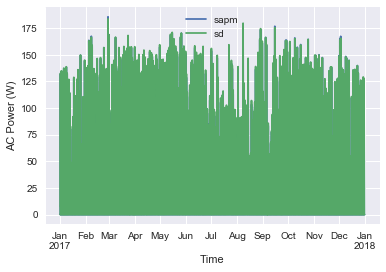

In [56]:
p_acs = pd.DataFrame()
p_acs['sapm'] = pvlib.pvsystem.snlinverter(sapm_out.v_mp, sapm_out.p_mp, sapm_inverter)
p_acs['sd'] = pvlib.pvsystem.snlinverter(single_diode_out.v_mp, single_diode_out.p_mp, sapm_inverter)

mask = p_acs['sapm'] < 0
p_acs.loc[mask, 'sapm'] = 0

mask = p_acs['sd'] < 0
p_acs.loc[mask, 'sd'] = 0

p_acs.plot()
plt.ylabel('AC Power (W)')

Text(0,0.5,'SAPM - SD Power (W)')

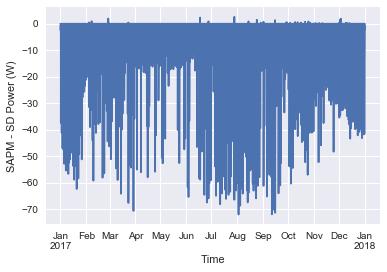

In [30]:
diff = p_acs['sapm'] - p_acs['sd']
diff.plot()
plt.ylabel('SAPM - SD Power (W)')

Plot just a few days.

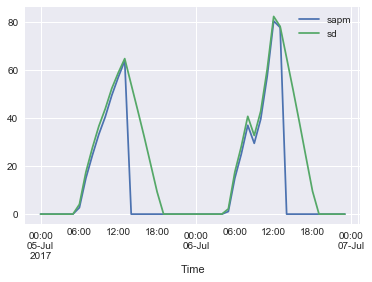

In [32]:
p_acs['2017-07-05':'2017-07-06'].plot()

Some statistics on the AC power

In [33]:
p_acs.describe()

,sapm,sd
count,8760.000000,8760.000000
mean,23.226629,28.576668
std,43.113331,43.619603
min,-0.020000,-0.020000
25%,-0.020000,-0.020000
50%,-0.020000,-0.020000
75%,27.611670,46.718422
max,185.618077,183.658418


In [34]:
p_acs.sum()

sapm    203465.272421
sd      250331.612434
dtype: float64

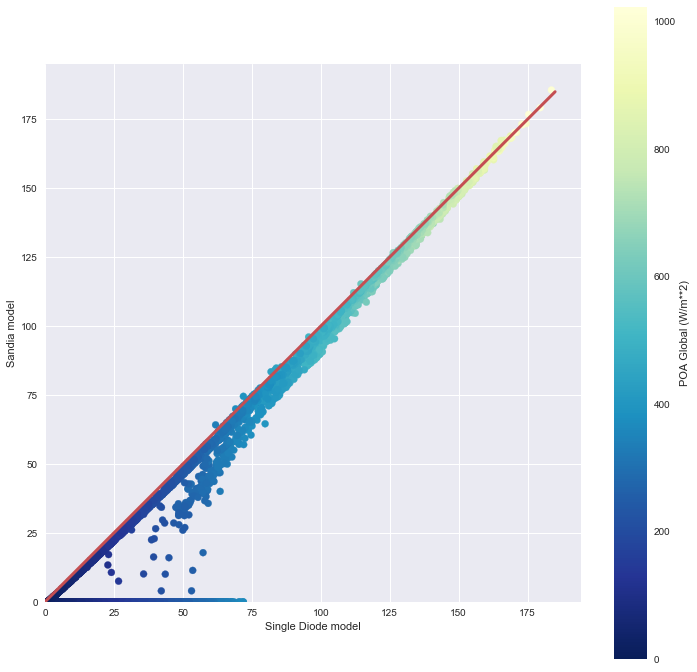

In [37]:
# create data for a y=x line
p_ac_max = p_acs.max().max()
yxline = np.arange(0, p_ac_max)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, aspect='equal')
sc = ax.scatter(p_acs['sd'], p_acs['sapm'], c=poa_irrad.poa_global, alpha=1, cmap=mpl.cm.YlGnBu_r)  
ax.plot(yxline, yxline, 'r', linewidth=3)
ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.set_xlabel('Single Diode model')
ax.set_ylabel('Sandia model')
fig.colorbar(sc, label='POA Global (W/m**2)')

We can change the value of color value ``c`` to see the sensitivity of model accuracy to measured meterological conditions. It can be useful to define a simple plotting function for this kind of exploratory analysis.

In [38]:
def sapm_sd_scatter(c_data, label=None, **kwargs):
    """Display a scatter plot of SAPM p_ac vs. single diode p_ac.
    
    You need to re-execute this cell if you re-run the p_ac calculation.
    
    Parameters
    ----------
    c_data : array-like
        Determines the color of each point on the scatter plot.
        Must be same length as p_acs.
        
    kwargs passed to ``scatter``.
    
    Returns
    -------
    tuple of fig, ax objects
    """
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, aspect='equal')
    sc = ax.scatter(p_acs['sd'], p_acs['sapm'], c=c_data, alpha=1, cmap=mpl.cm.YlGnBu_r, **kwargs)  
    ax.plot(yxline, yxline, 'r', linewidth=3)
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    ax.set_xlabel('Single diode model power (W)')
    ax.set_ylabel('Sandia model power (W)')
    fig.colorbar(sc, label='{}'.format(label), shrink=0.75)
    
    return fig, ax

(<matplotlib.figure.Figure at 0x19c8af66e10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19c8b96b5c0>)

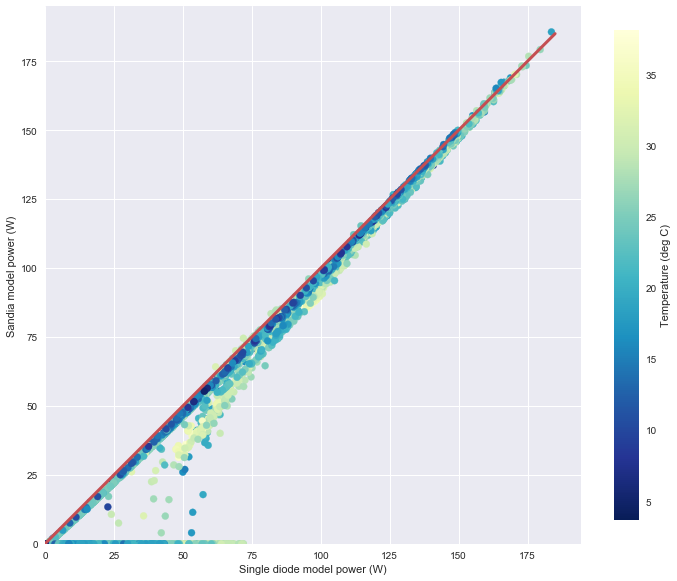

In [40]:
sapm_sd_scatter(tmy_data.tdb, label='Temperature (deg C)')

(<matplotlib.figure.Figure at 0x19c8ad73390>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19c896f7400>)

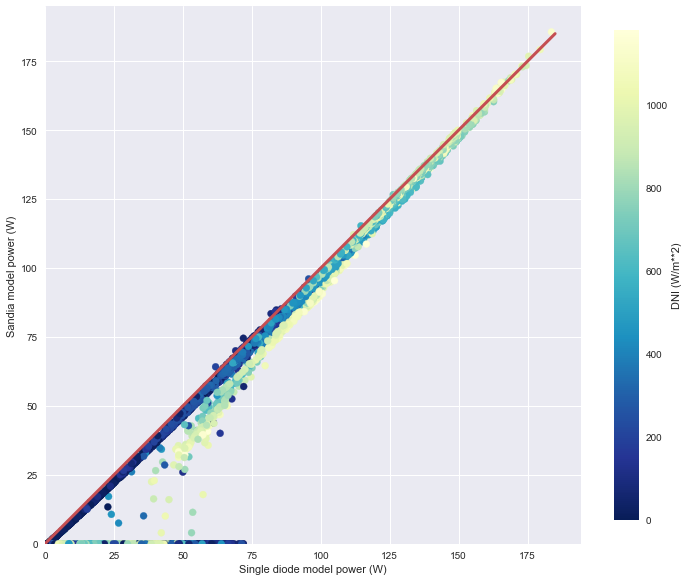

In [41]:
sapm_sd_scatter(tmy_data.dni, label='DNI (W/m**2)')

In [42]:
# sapm_sd_scatter(tmy_data.AOD, label='AOD')

AttributeError: 'DataFrame' object has no attribute 'AOD'

(<matplotlib.figure.Figure at 0x19c8b72a438>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19c8ba57160>)

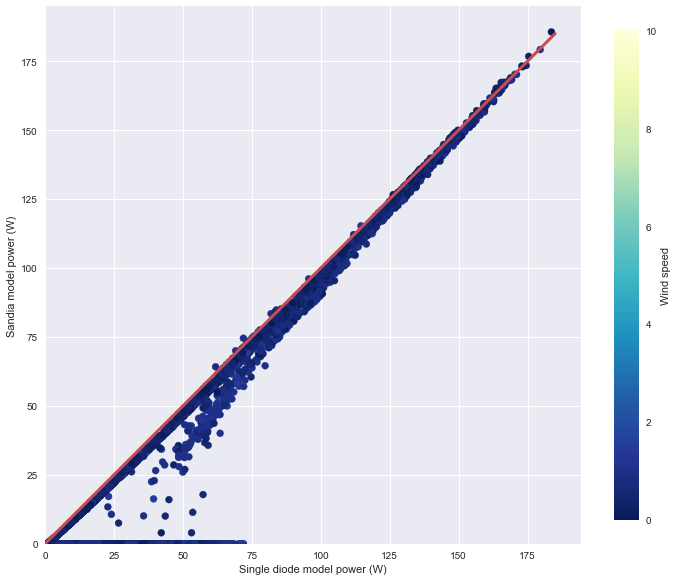

In [43]:
sapm_sd_scatter(tmy_data.wspd, label='Wind speed', vmax=10)

Notice the use of the ``vmax`` keyword argument in the above example. The ``**kwargs`` pattern allows us to easily pass non-specified arguments to nested functions.

In [44]:
def sapm_other_scatter(c_data, x_data, clabel=None, xlabel=None, aspect_equal=False, **kwargs):
    """Display a scatter plot of SAPM p_ac vs. something else.
    
    You need to re-execute this cell if you re-run the p_ac calculation.
    
    Parameters
    ----------
    c_data : array-like
        Determines the color of each point on the scatter plot.
        Must be same length as p_acs.
    x_data : array-like
        
    kwargs passed to ``scatter``.
    
    Returns
    -------
    tuple of fig, ax objects
    """
    
    fig = plt.figure(figsize=(12,12))
    
    if aspect_equal:
        ax = fig.add_subplot(111, aspect='equal')
    else:
        ax = fig.add_subplot(111)
    sc = ax.scatter(x_data, p_acs['sapm'], c=c_data, alpha=1, cmap=mpl.cm.YlGnBu_r, **kwargs)  
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    ax.set_xlabel('{}'.format(xlabel))
    ax.set_ylabel('Sandia model power (W)')
    fig.colorbar(sc, label='{}'.format(clabel), shrink=0.75)
    
    return fig, ax

(<matplotlib.figure.Figure at 0x19c8b82f748>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19c8abed668>)

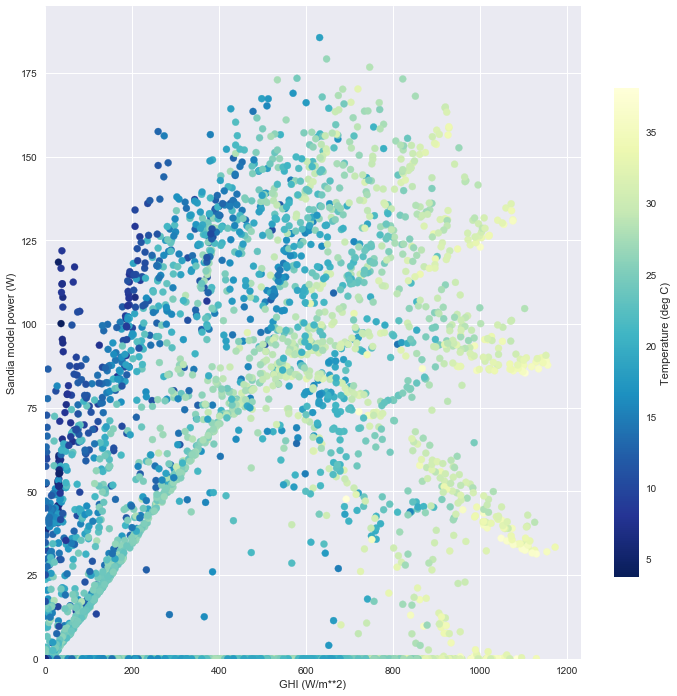

In [46]:
sapm_other_scatter(tmy_data.tdb, tmy_data.ghi, clabel='Temperature (deg C)', xlabel='GHI (W/m**2)')